
# Временные ряды 4. Построение и оценка модели
##                                                              Обучаем и предсказываем

Явления во времени можно рассматривать как "черный ящик", который зависит от многих переменных.Содержание ящика нам неизвестно, но его реакции на некоторые внешние воздействия мы можем наблюдать на примерах. Если наш гипотетический котенок, которого мы выращиваем, бегает за игрушкой каждый день, то мы можем предположить, что "черный ящик - котенок" почему-то реагирует на игрушку именно беготней. Нам вообще не важно как устроен котенок, мы видим постоянное явление: достали игрушку - котенок бегает. Более того, рассматривая довольно сложное явление траекторию движений котенка, мы можем это явление представить в виде некоторого временного ряда, где координаты от времени и связаны с предшествующим положением котенка (он же не телепортируется) и экзогенными факторами (траекторией движения игрушки или количеством вусняшек в миске котенка). Если при этом мы не пробуем описать устройство котенка, а только ищем связи между измеряемыми параметрами (признаками), то мы собираемся решить задачу обучения регрессионной модели нашего явления.    

Попробуем понять, как построить модель явления во времени в такой форме. Вернемся к нашим рядам: "Потребление энергии" и "Цена нефти BRENT". Будем использовать предобработанные версии этих рядов с признаками из календаря.   


## Потребление энергии

Временной ряд связан с измерением потребления энергии в отдельных регионах США в период 2002 по 2018 г. (PJM Hourly Energy Consumption Data
https://www.kaggle.com/robikscube/hourly-energy-consumption). Содержит часовые измерения и после обработки добавлены метки по времени для календаря.


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error
import os

Загрузим файл с данными и посмотрим на таблицу их организующую.

In [2]:
#Path_Energy = 'PJME_hourly.csv'
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])

data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


Общий вид изменения ключевого свойства ряда приведен на рис.1.

C:\Program Files\Python37\lib\site-packages\pandas\plotting\_matplotlib\converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


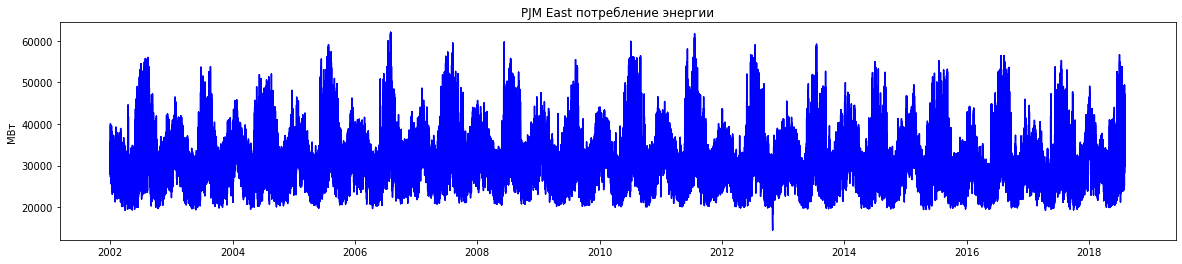

In [3]:
plt.figure(figsize =(20,4))
plt.plot( data.index, data['PJME_MW'], 'b' )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

Рис.1. Потребление энергии

## Brent 2010-2019
Перейдем ко второму примеру. Цена нефти марки Brent. Данные по дням от 2010 до 2019 . Данные были обработаны, но не меняли основное содержание ключевого признака. Отличие от исходного описания - дополнение признаками по календарю, как и в первом примере.

In [5]:

#path_brent = 'brent_cl_m5_20120101_20121231.csv'
#brent_data['Значение'] =brent_data['CLOSE']
#brent_data = pd.read_csv(path_brent,sep = ';', index_col=[0], parse_dates=[0])
path_brent = 'my_BRENT2019.csv'
brent_data = pd.read_csv(path_brent,sep = ',', index_col=[0], parse_dates=[0])
brent_data.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0


Общий вид изменения цены по ряду приведен на рис.2.

Text(0.5, 0, 't')

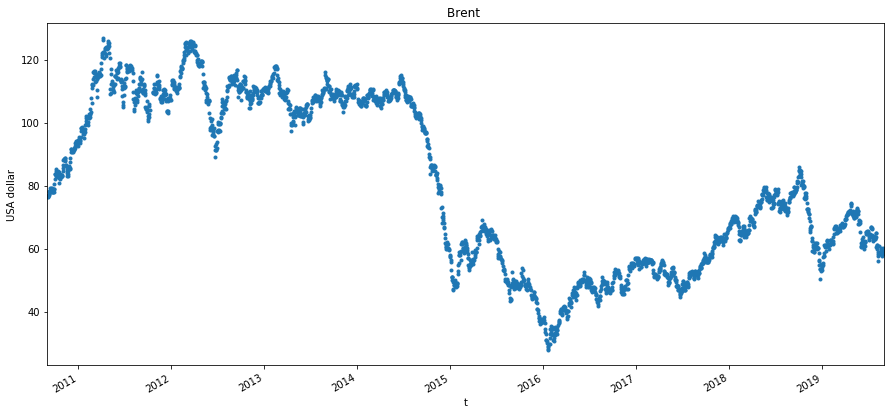

In [6]:
_ = brent_data['Значение'].plot( style='.', figsize=( 15, 7 ), title='Brent ')
plt.ylabel('USA dollar')
plt.xlabel('t')

Рис.3 Цена нефти с 2010 по 2019

### Методы машинного обучения для анализа рядов

Попробуем построить предсказание значений наших рядов на основании исследования отдельных примеров прошлого и различных параметров окружающих наши данные (календарь, макроэкономические показатели и т.п.). Основные типы обучаемых моделей можно разобрать на 2 группы :
- модель из одного решателя (линейная регрессия, нелинейная регрессия),
- ансамбль решателей (т.е. "коллектив" функций, который вычислит общее мнение). Это, например, модели типа адаптивного бустинга.
модели с одним решателем опираются на "опыт" единственного эксперта, который наблюдает явление и запоминает исходы при различных начальных условиях и в различные моменты времени. Ансамбли генерируют группу для совместной оценки, которая строит несколько решений одновременно и объединяет их в один ответ.

Привлекательность моделей предсказания значений временных рядов на основе обучения связана с тем, что нет необходимости проводить оценку сложности неизвестной на входе в задачу модели связывающей прогнозируемую величину с ее предшествующими значениями или другими временными рядами. Фактически можно взять все, что есть в наличии и заложить в обучаемую модель как входные переменные. Практически так делать не стоит, т.к. "плохие" признаки в обучаемой модели усложнят ее и приведут к неустойчивой работе в части рабочего диапазона. Таким образом схема решения задачи прогнозирования для временных рядов в обучаемых моделях принимает вполне привычный для машинного обучения вид:
- получить исходный ряд,
- определить список экзогенных факторов (внешних по отношению к прогнозируемому ряду), которые вероятно влияют на прогноз,
- определить глубину связей внутри ряда (ACF, PACF в помощь),
- преобразовать признаки - feature engenering,
- провести анализ признаков на важность и отделить важные - feature selection,
- построить первичный набор моделей и выбрать модель для тонкой настройки,
- подобрать гиперпараметры и провести обучение финальной модели,
- оценить качество модели и вернуться к предшествующим этапам при необходимости.

Следующий вопрос , который нужно решить, касается способа извлечения прогноза. Если мы следим за траекторией движения котенка, то у нас есть 2 варианта как определить его прогнозное положение через 1 минуту:

1 ) предсказывать прямо действия котенка через 1 минуту, т.е. построить решатель f(x(t), ..,x(t-p),y(t),..,y(t-p),t) = y(t+1),x(t+1), где x(t), ..,x(t-p),y(t),..,y(t-p) - координаты котенка в последние р моментов времени и t - текущий момент, t+1 момент наблюдений, который наступит через 1 минуту и , соответственно, прогнозные координаты y(t+1),x(t+1).

2 ) предсказывать f(x(t), ..,x(t-p),y(t),..,y(t-p),t) = y(t+dt),x(t+dt), т.е. предсказывать положение через dt<1 минуты, но проделать 1/dt циклов автопрогноза, опираясь на промежуточные y(t+dt),x(t+dt) , до достижения заданного горизонта прогнозирования.

**Спрашивается, какая тактика приносит успех?** Понятно, что чем дальше прогнозируемая точка, тем больше ошибка прогноза. Если мы попробуем предсказать, где будет котенок через 10 минут, вероятность угадать может быть близкой к 0. С другой стороны, если поведение объекта циклично, то наши шансы на успех значительно вырастут. Поэтапное прогнозирование на небольшом промежутке предсказания, хотя бы сначала, будет давать лучшее решение, т.к. короче интервал прогноза. Однако попадание в точку желаемого горизонта прогноза потребует применить f(x(t), ..,x(t-p),y(t),..,y(t-p),t) = y(t+dt),x(t+dt) 1/dt раз, что приводит к потере времени и накоплению ошибок.

Таким образом, следует обратиться к содержанию задачи прогнозирования и определить, уровень допустимой ошибки и что важнее в конкретных условиях: непрерывность решения (вариант 2) или получение конкретной точки (вариант генерации прогноза 1).

Рассмотрим построение модели прогнозирования точек ряда для наших рабочих примеров.


## Генерация признаков

Построение признаков во временных рядах значительно зависит от семантики ряда и его проблемной области. Например, если мы пытаемся предсказывать биржевые показатели, то очевидно, что наш ряд зависит от календаря и внешних экономических причин (экзогенных факторов), которые никаким способом извлечь из самого ряда не выйдет. Другой случай, короткое предсказание аудиосигнала при обработке звука. Звук непрерывен и имеет выраженный периодический характер, что позволяет использовать новые признаки - коэффициенты спектрограмм или результаты вейвлет-анализа. Обычно, конечно , для звуковых рядов решают не задачу предсказания, а задачу оценки-классификации. Это еще один аспект анализа временных рядов, о котором поговорим в следующей теме. Однако, очевидно, что признаки, которые отлично сработают в одних рядах и задачах не сработают в других, внешне похожих, ситуациях. Будем рассматривать признаки влияние, которых на прогнозирование обычно положительно.

Первый слой таких признаков мы уже построили - это признаки из календаря, которые позволяют увязывать сезоны, дни недели и часы дня. Выберем в качестве горизонт прогнозирования ряда "Потребление энергии" - среднее потребление в день на 1 день вперед. Это подразумевает, что часовая точность ряда нам не нужна. Сделаем ресемплинг на дни


In [7]:
data_d = data.copy().resample('D').mean()
data_d.head()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,
2002-01-01,31080.739130,2002.0,1.0,1.0,1.0,1.0,1.0,1.0,12.0,1.0,0.0,0.0
2002-01-02,34261.541667,2002.0,1.0,2.0,1.0,2.0,1.0,2.0,11.5,0.0,0.0,1.0
2002-01-03,34511.875000,2002.0,1.0,3.0,1.0,3.0,1.0,3.0,11.5,0.0,0.0,0.0
2002-01-04,33715.458333,2002.0,1.0,4.0,1.0,4.0,1.0,4.0,11.5,0.0,0.0,0.0
2002-01-05,30405.125000,2002.0,1.0,5.0,1.0,5.0,1.0,5.0,11.5,0.0,0.0,0.0


Удалим данные о часах, т.к. они потеряли актуальность

In [8]:
data_d.drop('hour', axis=1,inplace=True)
data_d.head()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,
2002-01-01,31080.739130,2002.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
2002-01-02,34261.541667,2002.0,1.0,2.0,1.0,2.0,1.0,2.0,0.0,0.0,1.0
2002-01-03,34511.875000,2002.0,1.0,3.0,1.0,3.0,1.0,3.0,0.0,0.0,0.0
2002-01-04,33715.458333,2002.0,1.0,4.0,1.0,4.0,1.0,4.0,0.0,0.0,0.0
2002-01-05,30405.125000,2002.0,1.0,5.0,1.0,5.0,1.0,5.0,0.0,0.0,0.0


Категорийные признаки ['year','month','dayofmonth','quarter','dayofyear','weekofyear','dayofweek'] не стоит превращать в dummy-переменную, т.к. это приведет к значительному увеличению базы.
Поскольку в годовом развороте ряда тренда нет (временные ряды 2 и 3), то признак 'year' можно исключить.


In [9]:
data_d.drop('year', axis=1,inplace=True)

In [10]:
data_d.iloc[:,:-1].head()

,PJME_MW,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday
Date,,,,,,,,,
2002-01-01,31080.739130,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2002-01-02,34261.541667,1.0,2.0,1.0,2.0,1.0,2.0,0.0,0.0
2002-01-03,34511.875000,1.0,3.0,1.0,3.0,1.0,3.0,0.0,0.0
2002-01-04,33715.458333,1.0,4.0,1.0,4.0,1.0,4.0,0.0,0.0
2002-01-05,30405.125000,1.0,5.0,1.0,5.0,1.0,5.0,0.0,0.0


Можно построить интегральный признак используя кластер-анализ или частичную классификацию. Начнем с признака по кластер-анализу. Воспользуемся методом kmeans, если можем предположить сколько будет кластеров, или DBSCAN, который не требует знания реального числа кластеров. 

In [11]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE 
import seaborn as sns

scl=StandardScaler()
tsne_ =TSNE(n_components=2)

X = data_d.iloc[:,:-1].values

Xscale = scl.fit_transform(X)
X_t = tsne_.fit_transform(Xscale)



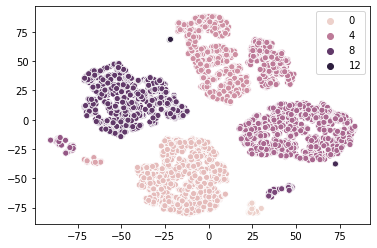

In [12]:
clast_0 = DBSCAN(eps=5, leaf_size=15 )
clast_1 = DBSCAN(eps=2, leaf_size=5)
X_clast =clast_0.fit_predict(X_t)
X_scale_clast =clast_1.fit_predict(Xscale)

sns.scatterplot(X_t[:,0],X_t[:,1], hue=X_clast)
plt.show()

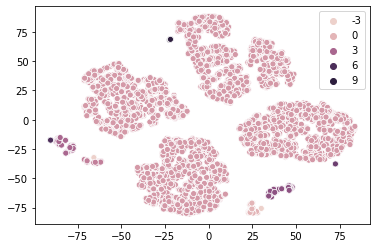

In [13]:
sns.scatterplot(X_t[:,0],X_t[:,1], hue=X_scale_clast )
plt.show()

Рис.3. Результат кластер-анализа признаков

In [14]:
print('Число кластеров в календаре с масштабированием: ',len(np.unique(X_scale_clast)))
print('Число кластеров в календаре: ',len(np.unique(X_clast)))

Число кластеров в календаре с масштабированием:  9
Число кластеров в календаре:  11


Вариант кластеризации с разметкой на рис.3 для случая масштабированных координат показывает отлично выделяемые кластеры с хорошим размещением объектов по группам. Принадлежность кластерам можно использовать в качестве нового признака и проверить качество обработки модели с новой координатой. В данном конкретном примере кластеризация без масштабирования, но с понижением размерности выглядит очень обосновано. Берем этот вариант за основу и добавим признак к общему описанию задачи. 

In [15]:
data_d['day_week_month'] = X_clast
data_d.iloc[np.where(data_d['day_week_month']==0)[0]].iloc[:10,:]

,PJME_MW,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,day_week_month
Date,,,,,,,,,,,
2002-01-01,31080.739130,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0
2002-01-21,32434.916667,1.0,21.0,1.0,21.0,4.0,0.0,1.0,0.0,0.0,0
2002-02-18,30929.125000,2.0,18.0,1.0,49.0,8.0,0.0,1.0,0.0,0.0,0
2002-05-27,26089.416667,5.0,27.0,2.0,147.0,22.0,0.0,1.0,0.0,0.0,0
2003-01-01,27603.708333,1.0,1.0,1.0,1.0,1.0,2.0,1.0,0.0,0.0,0
2003-01-20,35501.500000,1.0,20.0,1.0,20.0,4.0,0.0,1.0,0.0,0.0,0
2003-02-17,35268.625000,2.0,17.0,1.0,48.0,8.0,0.0,1.0,0.0,0.0,0
2003-05-26,24095.833333,5.0,26.0,2.0,146.0,22.0,0.0,1.0,0.0,0.0,0
2004-01-01,27885.250000,1.0,1.0,1.0,1.0,1.0,3.0,1.0,0.0,0.0,0


В выборке объектов типа 0 собраны праздничные дни, а в типе 2 нового признака собрали субботы перед праздником:).

In [16]:
data_d.iloc[np.where(data_d['day_week_month']==2)[0]].iloc[:10,:]

,PJME_MW,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,day_week_month
Date,,,,,,,,,,,
2002-01-20,29482.916667,1.0,20.0,1.0,20.0,3.0,6.0,0.0,1.0,0.0,2
2002-02-17,26883.250000,2.0,17.0,1.0,48.0,7.0,6.0,0.0,1.0,0.0,2
2002-05-26,24351.500000,5.0,26.0,2.0,146.0,21.0,6.0,0.0,1.0,0.0,2
2003-01-19,34429.750000,1.0,19.0,1.0,19.0,3.0,6.0,0.0,1.0,0.0,2
2003-02-16,35948.000000,2.0,16.0,1.0,47.0,7.0,6.0,0.0,1.0,0.0,2
2003-05-25,23621.875000,5.0,25.0,2.0,145.0,21.0,6.0,0.0,1.0,0.0,2
2003-08-31,28198.541667,8.0,31.0,3.0,243.0,35.0,6.0,0.0,1.0,0.0,2
2004-01-18,33026.291667,1.0,18.0,1.0,18.0,3.0,6.0,0.0,1.0,0.0,2
2004-02-15,31169.500000,2.0,15.0,1.0,46.0,7.0,6.0,0.0,1.0,0.0,2


Другой путь получения новых признаков применение преобразований для понижения размерности. Пример такого преобразования приведен выще в процессе построения признака из кластерного анализа , использовали редукцию пространства с использованием модели t-SNE. Однако, эта модель характерна высокой вычислительной сложностью, что увеличивает время решения задачи. Более простая, хотя и линейная модель, это PCA - метод главных компонент. Поскольку наши координаты календаря вполне связаны, то можно проверить и такой путь объединения признаков. Добавим признак на основе компонетного анализа. Построим 2 компоненты по признакам из календаря , без значений ряда и допишем их в общую таблицу data_d.

In [17]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, svd_solver='full')
Xpca=pca.fit_transform(Xscale[:,1:])
Xpca.shape

(6059, 2)

In [18]:
data_d['pca1']=Xpca[:,0]
data_d['pca2']=Xpca[:,1]

Добавим новых признаков, описывающих содержание ряда. К таким признакам можно отнести разности ряда и разнообразные варианты сглаживания. Добавим к нашей модели 1-е разности. При этом следует помнить, что такие операции уменьшают общую длину корректной выборки на 1, т.е. первую строку данных следует исключить из модели в момент обучения.

In [19]:
first_diff =np.array(data_d.iloc[1:,0].values - data_d.iloc[:-1,0].values).astype('float32') 
data_d['diff1'] = 0
data_d['diff1'] =  data_d['diff1'].astype('float') 
data_d['diff1'].values[1:] = first_diff

Вообще можно добавить все, что можем придумать. Например, логарифм признака, частные признаков , частные логарифмов и т.д. 

In [20]:
first_diff_d =(first_diff) / data_d.iloc[1:,0].values
data_d['diff1_d'] = 0
data_d['diff1_d'] =  data_d['diff1_d'].astype('float') 
data_d['diff1_d'].values[1:] = np.array(first_diff_d).astype('float32')

Можно, например, взять Бокс-Кокс преобразование (тут не работает, т.к. дисперсия постоянна - нет смысла)

In [21]:
import scipy.stats as scs
def invboxcox(y,lmbda):
    # обрабтное преобразование Бокса-Кокса
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

In [22]:
first_diff_l =np.log(data_d.iloc[1:,0].values) 
#first_diff_l, lmbda1 = scs.boxcox(data_d.iloc[1:,0].values) # НЕ РАБОТАЕТ , Т.К. АРГУМЕНТ ЛОГАРИФМА БЛИЗОК 0 
data_d['diff1_l'] = 0
data_d['diff1_l'] =  data_d['diff1_l'].astype('float') 
data_d['diff1_l'].values[1:] = first_diff_l

Добавим скользящее среднее по всей модели с глубиной 7 дней. Размер окна определен длиной недельных циклов.

In [23]:
data_d['d_w7']=data_d['PJME_MW'].rolling(window=7).mean()

А теперь добавим еще и экспонентциальную среднюю. Медленную, т.к. интересная информация лежит на уровне сезонных колебаний цены.

In [24]:
def exponential_smoothing(series, alpha):
    result = [series[0]] 
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

data_d['exp_0_05'] = exponential_smoothing(data_d['PJME_MW'], 0.05)


В итоге данные примут вид 

In [25]:
data_d.iloc[10:15,:]


,PJME_MW,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,day_week_month,pca1,pca2,diff1,diff1_d,diff1_l,d_w7,exp_0_05
Date,,,,,,,,,,,,,,,,,,
2002-01-11,30947.541667,1.0,11.0,1.0,11.0,2.0,4.0,0.0,0.0,0.0,1,-3.090058,-0.351464,-524.000000,-0.016932,10.340049,32088.672619,31698.654162
2002-01-12,28466.875000,1.0,12.0,1.0,12.0,2.0,5.0,0.0,0.0,0.0,1,-3.081461,-0.699271,-2480.666748,-0.087142,10.256496,31811.779762,31537.065204
2002-01-13,28052.833333,1.0,13.0,1.0,13.0,2.0,6.0,0.0,0.0,0.0,1,-3.072864,-1.047078,-414.041656,-0.014759,10.241845,31487.386905,31362.853610
2002-01-14,31602.958333,1.0,14.0,1.0,14.0,3.0,0.0,0.0,0.0,0.0,1,-3.032802,0.982834,3550.125000,0.112335,10.361006,31240.119048,31374.858846
2002-01-15,31223.791667,1.0,15.0,1.0,15.0,3.0,1.0,0.0,0.0,0.0,1,-3.024205,0.635026,-379.166656,-0.012144,10.348936,30791.672619,31367.305487


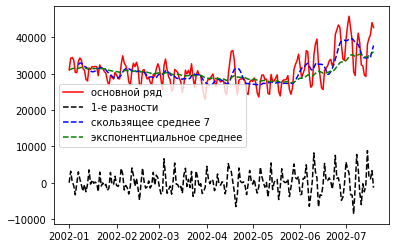

In [26]:
N100=200
plt.plot(data_d.index[:N100],data_d['PJME_MW'][:N100],'r',label ='основной ряд')
plt.plot(data_d.index[:N100],data_d['diff1'][:N100],'--k',label ='1-е разности')
plt.plot(data_d.index[:N100],data_d['d_w7'][:N100],'--b',label ='скользящее среднее 7')
plt.plot(data_d.index[:N100],data_d['exp_0_05'][:N100],'--g',label ='экспонентциальное среднее')
plt.legend()
plt.show()


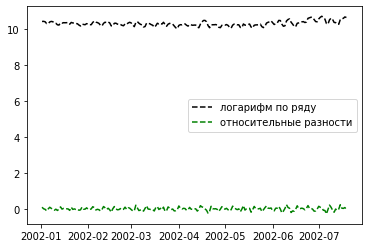

In [27]:
N100=200
plt.plot(data_d.index[1:N100],data_d['diff1_l'][1:N100],'--k',label ='логарифм по ряду')

plt.plot(data_d.index[1:N100],data_d['diff1_d'][1:N100],'--g',label ='относительные разности')
plt.legend()
plt.show()

Проблема состоит в том, что подобных признаков можно построить бесконечное количество. Для определения разумных интервалов имеет смысл вспомнить результаты анализа ряда в статистических моделях. Период сезонных колебаний 13 недель и недельный цикл по дням. Это позволит не строить все возможные сочетания параметров модели, а сократить их число до относительно небольшого подмножества. Посмотрим на примере экспоненциальных средних в диапазоне alpha = [0.3, 0.8] 

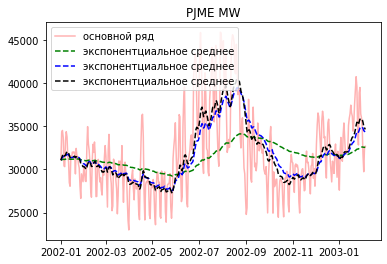

In [28]:
data_d['exp_0_01'] = exponential_smoothing(data_d['PJME_MW'], 0.01)
data_d['exp_0_03'] = exponential_smoothing(data_d['PJME_MW'], 0.03)
data_d['exp_0_04'] = exponential_smoothing(data_d['PJME_MW'], 0.04)
data_d['exp_0_06'] = exponential_smoothing(data_d['PJME_MW'], 0.06)
data_d['exp_0_07'] = exponential_smoothing(data_d['PJME_MW'], 0.07)
data_d['exp_0_08'] = exponential_smoothing(data_d['PJME_MW'], 0.08)

N100=400
plt.plot(data_d.index[:N100],data_d['PJME_MW'][:N100],'r',label ='основной ряд',alpha=0.3)
plt.plot(data_d.index[:N100],data_d['exp_0_01'][:N100],'--g',label ='экспонентциальное среднее')
plt.plot(data_d.index[:N100],data_d['exp_0_05'][:N100],'--b',label ='экспонентциальное среднее')
plt.plot(data_d.index[:N100],data_d['exp_0_08'][:N100],'--k',label ='экспонентциальное среднее')
plt.legend()
plt.title('PJME MW')
plt.show()

In [29]:
data_d.iloc[:7,14]=0

Добавим истории длиной p в признаках автокорреляции

In [30]:
p = 14
for i in range(p):
    data_d['t'+str(p-i)]=0
    data_d['t'+str(p-i)].values[p:] = data_d['PJME_MW'].values[i:-(p)+i]

Аналогично добавляем первые разности на глубину p

In [31]:
p = 14
for i in range(p):
    data_d['d'+str(p-i)]=0
    data_d['d'+str(p-i)].values[p:] = data_d['diff1'].values[i:-(p)+i]

Итоговая система признаков

In [32]:
data_d.head(10)

,PJME_MW,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,...,d10,d9,d8,d7,d6,d5,d4,d3,d2,d1
Date,,,,,,,,,,,,,,,,,,,,,
2002-01-01,31080.739130,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2002-01-02,34261.541667,1.0,2.0,1.0,2.0,1.0,2.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2002-01-03,34511.875000,1.0,3.0,1.0,3.0,1.0,3.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2002-01-04,33715.458333,1.0,4.0,1.0,4.0,1.0,4.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2002-01-05,30405.125000,1.0,5.0,1.0,5.0,1.0,5.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2002-01-06,30323.583333,1.0,6.0,1.0,6.0,1.0,6.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2002-01-07,33333.833333,1.0,7.0,1.0,7.0,2.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2002-01-08,34362.916667,1.0,8.0,1.0,8.0,2.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2002-01-09,33776.166667,1.0,9.0,1.0,9.0,2.0,2.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


## Выделение существенных признаков

Запишем итоговую систему признаков и проведем ее анализ. Горизонт прогнозирования h = 1, тогда target = y(t+h)=y(t+1) 

In [33]:
scl_target=StandardScaler() 
# p = 14
h=1
target = data_d['PJME_MW'].values[h+p:].reshape((data_d.shape[0]-h-p,1))
y = scl_target.fit_transform(target)
y.shape

(6044, 1)

Входной набор признаков берем из нашей таблицы. Необходимо помнить, что у нас есть интегральные признаки (для календаря), которые связаны с базовыми признаками. Обычно такие признаки рассматривают отдельно. Однако для эксперимента оставим все признаки для процедуры селекции.

In [34]:
scl_x=StandardScaler() 

X = data_d.iloc[p:-h,:].values
X = scl_x.fit_transform(X.astype('float64'))
X.shape

(6044, 52)

In [35]:
X[:7,14]=0

Размеры выборок по строкам совпали. Мы взяли на h строк меньше для Х и на h значений позднее по target. Таким образом, входной набор данных сформирован.

Как и во всех задачах обучения, системах признаков не идеальна. Есть признаки хорошие, а есть признаки плохие. Применим механизмы  селекции признаков для нашей модели. 
Рассмотрим механизмы селекции специфичные для регрессий и доступные из scikit-learn. Это два основных способа селекции: 
- построим или применим метрику взвешивающую связь признака и целевого свойства,
- проведем предварительное обучение и проверим влиятельность признаков по результатам такого обучения.

Такое решение задачи селекции признаков поддерживается через SelectKBest (отбираем k лучших признаков), SelectPercentile (отбираем заданный процент признаков) и SelectFromModel, соответственно(https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection). Посмотрим на результаты оценки нашей системы признаков.

In [36]:
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import f_regression, mutual_info_regression

f_test, _ = f_regression(X, y.ravel())
f_test /= np.max(f_test)
for i in range(X.shape[1]):
    print("F-test={:.2f},  I={}".format(f_test[i],i))


F-test=1.00,  I=0
F-test=0.00,  I=1
F-test=0.00,  I=2
F-test=0.00,  I=3
F-test=0.00,  I=4
F-test=0.00,  I=5
F-test=0.01,  I=6
F-test=0.00,  I=7
F-test=0.00,  I=8
F-test=0.00,  I=9
F-test=0.00,  I=10
F-test=0.00,  I=11
F-test=0.01,  I=12
F-test=0.05,  I=13
F-test=0.05,  I=14
F-test=0.95,  I=15
F-test=0.45,  I=16
F-test=0.24,  I=17
F-test=0.03,  I=18
F-test=0.13,  I=19
F-test=0.19,  I=20
F-test=0.29,  I=21
F-test=0.32,  I=22
F-test=0.35,  I=23
F-test=0.13,  I=24
F-test=0.19,  I=25
F-test=0.15,  I=26
F-test=0.10,  I=27
F-test=0.10,  I=28
F-test=0.10,  I=29
F-test=0.12,  I=30
F-test=0.19,  I=31
F-test=0.27,  I=32
F-test=0.21,  I=33
F-test=0.15,  I=34
F-test=0.15,  I=35
F-test=0.18,  I=36
F-test=0.29,  I=37
F-test=0.01,  I=38
F-test=0.01,  I=39
F-test=0.00,  I=40
F-test=0.01,  I=41
F-test=0.00,  I=42
F-test=0.00,  I=43
F-test=0.00,  I=44
F-test=0.01,  I=45
F-test=0.01,  I=46
F-test=0.00,  I=47
F-test=0.01,  I=48
F-test=0.00,  I=49
F-test=0.00,  I=50
F-test=0.01,  I=51


Проверка через F-test показывает, что есть корреляционная связь с предшествующим значением ряда (признак X[:,0]), а кроме этого интересные признаки  от 14 до 21. Применим автоматизацию выбора через SelectKBest c выделением 5 лучших признаков.

In [37]:
sfk =SelectKBest(f_regression, k=5)
X_new1 =sfk.fit_transform(X, y.ravel())
X_new1.shape

(6044, 5)

In [38]:
column_names = data_d.columns[sfk.get_support()]
column_names

Index(['PJME_MW', 'diff1_l', 'd_w7', 'exp_0_07', 'exp_0_08'], dtype='object')

In [39]:
X_new1[295:300,:]

array([[-0.37761276, -0.32657486, -0.56861581, -0.84178796, -0.82611987],
       [-0.33360836, -0.27891084, -0.58196677, -0.81526224, -0.79618379],
       [-0.44669275, -0.40205862, -0.60919327, -0.80164763, -0.78096838],
       [-1.24116149, -1.33405657, -0.68243896, -0.86664752, -0.8535644 ],
       [-1.51842301, -1.6907953 , -0.76794307, -0.95420048, -0.95057324]])

Лучшее множество признаков отделено в X_new1. Проверим результат оценки признаков по процентному отбору и сохраним его в X_new2.

In [40]:
sfp=SelectPercentile(f_regression, percentile=10)
X_new2 = sfp.fit_transform(X, y.ravel())
X_new2.shape

(6044, 6)

In [41]:
column_namesp = data_d.columns[sfp.get_support()]
column_namesp

Index(['PJME_MW', 'diff1_l', 'd_w7', 'exp_0_07', 'exp_0_08', 't1'], dtype='object')

Наконец, третий вариант - применим выделение признаков через построение модели. Помним, что модель должна уметь выбрать подмножество признаков или вернуть коэффициент их влиятельности. Это ограничивает выбор моделей. Возьмем как оценшик GradientBoostingRegressor и построим новое пространство в X_new3

In [42]:
gr_model = GradientBoostingRegressor(max_depth=5, random_state=40, n_estimators=100).fit(X, y.ravel())
sfm = SelectFromModel(gr_model,  max_features = 5)

sfm.fit(X, y.ravel())
X_new3 = sfm.transform(X)
X_new3.shape

(6044, 5)

Сравним результаты:


In [43]:
[X_new1[10:15,:], X_new2[10:15,:],X_new3[10:15,:]]

[array([[-0.40418062, -0.35550964, -0.24599883, -0.2237753 , -0.22389016],
        [-0.85339153, -0.86370256, -0.38408476, -0.29132068, -0.29878693],
        [-1.15847336, -1.23108168, -0.48585871, -0.38396047, -0.40094476],
        [-0.5525556 , -0.51933277, -0.59156935, -0.41088536, -0.42888714],
        [-0.65053957, -0.62965222, -0.68165281, -0.44550371, -0.46527402]]),
 array([[-0.40418062, -0.35550964, -0.24599883, -0.2237753 , -0.22389016,
         -0.31194499],
        [-0.85339153, -0.86370256, -0.38408476, -0.29132068, -0.29878693,
         -0.40405925],
        [-1.15847336, -1.23108168, -0.48585871, -0.38396047, -0.40094476,
         -0.85332949],
        [-0.5525556 , -0.51933277, -0.59156935, -0.41088536, -0.42888714,
         -1.15845797],
        [-0.65053957, -0.62965222, -0.68165281, -0.44550371, -0.46527402,
         -0.55246556]]),
 array([[-0.40418062,  0.50032063, -0.42174257, -0.35550964, -0.03167813],
        [-0.85339153,  1.00039305, -0.73736712, -0.86370256, 

In [44]:
list_param_k =np.where(sfk.get_support())[0]
list_param_p =np.where(sfp.get_support())[0]
list_param_m =np.where(sfm.get_support())[0]

print('Номера признаков k лучших признаков : ',list_param_k)
print('Номера признаков лучших признаков по процентной форме: ',list_param_p)
print('Номера признаков для выбора по модели : ',list_param_m)

Номера признаков k лучших признаков :  [ 0 15 16 22 23]
Номера признаков лучших признаков по процентной форме:  [ 0 15 16 22 23 37]
Номера признаков для выбора по модели :  [ 0  6 12 15 32]


Пересечение выбора по отбору для модели и по количественным оценкам связи в признаке 0. Имеет смысл брать объединение выборов. Возьмем [0,6,12,16,15,22,23, ...] признаки и перейдем к построению модели.

In [45]:
list_par=[0,6,12,16,15,22,23,25,32, 37]
X_new = X[:,list_par]
data_d.columns[list_par]

Index(['PJME_MW', 'dayofweek', 'pca2', 'd_w7', 'diff1_l', 'exp_0_07',
       'exp_0_08', 't13', 't6', 't1'],
      dtype='object')

In [46]:
from sklearn.linear_model import LinearRegression 


## Разделение данных на тестовые и тренировочные 

Построение модели начинаем с выделения тестовой части нашего ряда. Напомним, что для временных рядов тест - непрерывная часть ряда не входившая в обучение (временные ряды 1). Будем отделять по индексу, который задаст дату разделения модели на тест и обучение.

In [47]:
# сделаем функцию
def split_data( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

Для временного ряда "Потребление энергии" назначим датой разделения 1/06/2016

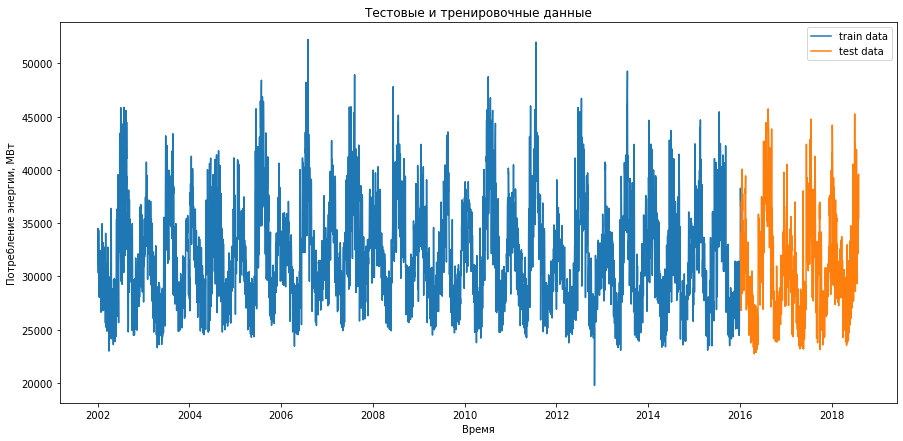

In [48]:
train, test = split_data( data_d, '01-06-2016')

plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(train.index.get_level_values('Date'),train['PJME_MW'], label='train data' )
plt.plot(test.index.get_level_values('Date'),test['PJME_MW'], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [49]:
X_train =X_new[:train.shape[0],:]
y_train =y[:train.shape[0],0]
X_test =X_new[train.shape[0]:,:]
y_test =y[train.shape[0]:,0]

In [50]:
train.shape

(5119, 52)

Выделим описание объекта и целевое свойство для тестовой и тренировочной частей ряда. Перейдем к построению моделей.  

# Строим Модель

При решении задачи на начальном этапе, самый интересный результат был получен на модели GradientBoostingRegressor. Остановимся на построении иенно такой формы предсказания. Импортируем необходимые модели.

In [51]:
from sklearn.ensemble import GradientBoostingRegressor

In [52]:
model_g = GradientBoostingRegressor(max_depth=5, random_state=0, n_estimators=100)

Запускаем модели и смотрим , что они построят на наших примерах.

In [53]:
model_g.fit( X_train, y_train ) # 

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto', random_state=0,
                          subsample=1.0, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

**Посмотрим тесты**

In [54]:
X_test.shape

(925, 10)

In [55]:
y_test_pred_g = model_g.predict(X_test)

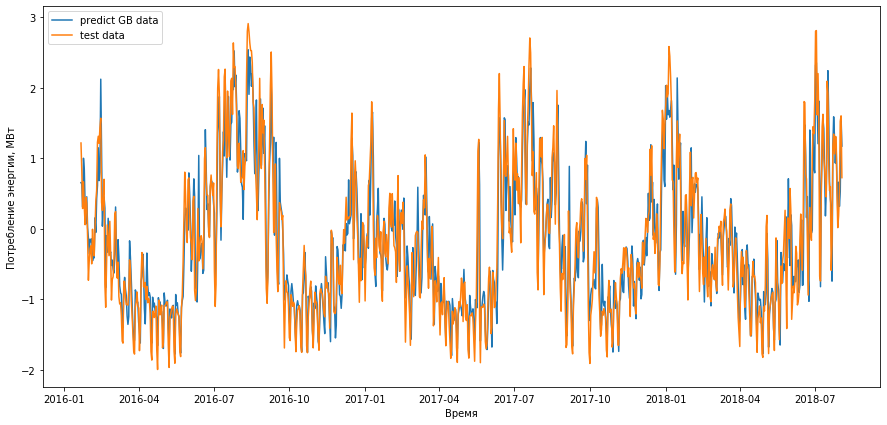

In [56]:

plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[h+p:],y_test_pred_g, label='predict GB data' )
plt.plot(test.index[h+p:],y_test, label='test data')

plt.legend()
plt.show()

**Оценки для сравнения моделей**

Оценим промах модели, используя метрики, которые можно применять для оценки регрессий https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics:
- средне-квадратичное отклонение
- среднюю абсолютную ошибку
- коэфиициент детерминации 

In [57]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


In [58]:
er_s = mean_squared_error(y_true=y_test, y_pred=y_test_pred_g) 
er_a = mean_absolute_error(y_true=y_test, y_pred=y_test_pred_g) 
er_r2 = r2_score(y_true=y_test, y_pred=y_test_pred_g)

print('ошибка mse :  ', er_s,'\nошибка mae  :  ', er_a,'\nоценка R2 :  ', er_r2)

ошибка mse :   0.166191778089794 
ошибка mae  :   0.306703226033143 
оценка R2 :   0.8402503636590625


Абсолютная процентная ошибка (MAPE).Обратите внимание, что определять ее для масштабированной переменной не верно. Пожэтому переведем ответ решателя обратно в состояние без масштаба.

In [59]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [60]:
er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_pred_g))

print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   4.552927356464014 %


Анализ на отсутствие корреляции с последующим ответом (проверяем не делаем ли предсказание в стиле "завтра==сегодня")

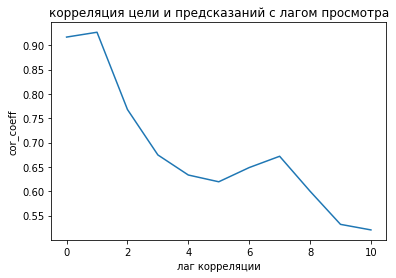

In [61]:
lag=10
p_cor=[np.corrcoef( y_test, y_test_pred_g)[1,0]]
for i in range(lag):
    c=np.corrcoef( y_test[:-(i+1)], y_test_pred_g[(i+1):])[1,0]
    p_cor.append(c)    

plt.plot(np.array(p_cor) )  
plt.xlabel('лаг корреляции')
plt.ylabel('cor_coeff')
plt.title('корреляция цели и предсказаний с лагом просмотра')
plt.show()

Поскольку самое большое значение корреляции не с первым ответом, то не все хорошо. Однако корреляция при лаге 1 меньше 1, а это уже неплохо. 

Ошибка неплоха, но мы имеем дело с маленьким горизонтом прогноза и тем неменее пока точность предсказания не превышает 95%. 
Построим более точную модель с использованием поиска моделей. Воспользуемся методом поиска 

In [62]:
from sklearn.model_selection import RandomizedSearchCV

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

param_dist = {"max_depth": [3, 2,10,14,5], 
              "n_estimators":[100,200,300,400,500, 1000, 1200,1500]}

#  randomized search
n_iter_search = 10

model_gr =GradientBoostingRegressor()

random_search = RandomizedSearchCV(model_gr, param_distributions=param_dist, n_iter=n_iter_search, cv=5, iid=False)

random_search.fit(X_train, y_train)

report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.853 (std: 0.007)
Parameters: {'n_estimators': 500, 'max_depth': 3}

Model with rank: 2
Mean validation score: 0.851 (std: 0.007)
Parameters: {'n_estimators': 200, 'max_depth': 5}

Model with rank: 3
Mean validation score: 0.847 (std: 0.006)
Parameters: {'n_estimators': 400, 'max_depth': 5}



Выбираем модель с рангом 1. {'n_estimators': 1200, 'max_depth': 2} (в одном из запусков RandomizedSearchCV был лучший резльтат) и проведем ее обучение на тренировочном наборе.

In [63]:
model_g_best = GradientBoostingRegressor(max_depth=2,  n_estimators=1200)
model_g_best.fit( X_train, y_train ) 
y_test_pred_g = model_g_best.predict(X_test)

er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_pred_g))
print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   4.594147860657287 %


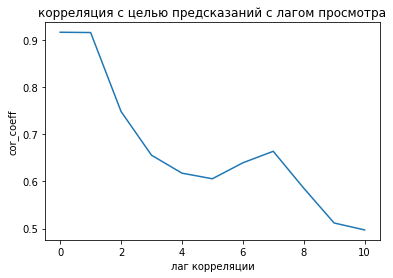

In [64]:
lag=10
p_cor=[np.corrcoef( y_test, y_test_pred_g)[1,0]]
for i in range(lag):
    c=np.corrcoef( y_test[:-(i+1)], y_test_pred_g[(i+1):])[1,0]
    p_cor.append(c)    

plt.plot(np.array(p_cor) )  
plt.xlabel('лаг корреляции')
plt.ylabel('cor_coeff')
plt.title('корреляция с целью предсказаний с лагом просмотра')
plt.show()

По корреляциям результат не идеальный , но приемлемый.
Качество решения задачи по MAPE повысилось почти на 0.03%. Очевидно, что диапазон вариаций значений был довольно узким и есть возможность поискать решение в более широком выборе параметров и их значений. Кроме того, провели всего 10 итераций поиска, что также не позволяет гарантировать идеальный ответ. Однако даже в такой версии за несколько минут поиска удается улучшить результат исходной модели. 

## Сохраниение модели

In [65]:
import pickle
# save the model to disk
filename = 'final_model.sav'
pickle.dump(model_g_best, open(filename, 'wb'))

filename = 'final_scaler_y.sav'
pickle.dump(scl_target, open(filename, 'wb'))

filename = 'final_scaler_x.sav'
pickle.dump(scl_x, open(filename, 'wb'))


In [66]:
scl_x.scale_[0] , scl_x.mean_[0]

(4690.818091999314, 32079.77111742383)

In [67]:
scl_x.scale_[32] , scl_x.mean_[32]

(4689.296392249715, 32074.548146922567)

## Использование модели для предсказания n*h моментов времени

Мы построили короткий прогноз, но его можно продолжить на следующие точки ряда. Для этого будем использовать результаты прогноза для следующего шага.  Необходимо заменять X_test[t+i, 0] = y_test[t+i-1] и продолжить моделирование в новом состоянии. Сделаем 10 дней прогноза.

In [68]:
X_test_100 = X_test.copy()

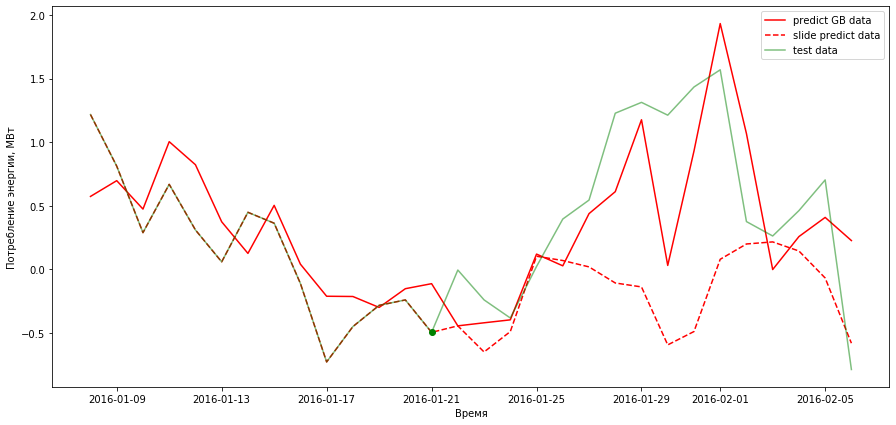

In [69]:
# ['PJME_MW', 'dayofweek', 'pca2', 'd_w7', 'diff1_l', 'exp_0_07','exp_0_08', 't6', 't1']
# ['PJME_MW', 'dayofweek', 'pca2', 'd_w7', 'diff1_l', 'exp_0_07','exp_0_08', 't13', 't6', 't1']
#['PJME_MW', 'dayofweek', 'pca2', 'd_w7', 'diff1_l', 'exp_0_07', 'exp_0_08']
 
X_test_100 = X_test.copy()
y_test_100 = y_test.copy()
N10 = 30
for i in range(p,N10+p):
    y_test_100[i] = model_g_best.predict(X_test_100[i,:].reshape((1,X_test_100.shape[1])))
    # восстанавливаем не масштабированное значение ряда текущей точке  
    y_i=scl_target.inverse_transform(y_test_100[i:i+1]  )
                                     
    # заполняем вектор для прогноза следующей точки
    X_test_100[i+1,0] = (y_i-scl_x.mean_[0])/scl_x.scale_[0]
    #строим 'exp_0_07', 'exp_0_08'
    X_test_100[i+1,6] = X_test_100[i,6]*(1-0.08)+ 0.08 * X_test_100[i+1,0] 
    X_test_100[i+1,5] = X_test_100[i,5]*(1-0.07)+ 0.07 * X_test_100[i+1,0] 
    #строим 'd_w7' - признак под номером 3
    X_test_100[i+1,3] = np.mean(X_test_100[i-6:i+1,0]) 
    #строим 'diff1_l' - признак под номером 4
    # строим логарифм по значению ряда и скалируем признак по схеме 15-го признака из основного списка
    xy_i=(np.log((y_i))-scl_x.mean_[15])*scl_x.scale_[15]
    #устанавливаем новое значение для 4
    X_test_100[i+1,4] = xy_i 
    # обновим историю значенний
    X_test_100[i+1,7] = X_test_100[i-13,0]
    X_test_100[i+1,8] = X_test_100[i-6,0]
    
    X_test_100[i+1,9] = X_test_100[i-1,0]
        
    
    
plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[1:N10+1],y_test_pred_g[:N10], 'r',label='predict GB data' )
plt.plot(test.index[1:N10+1],y_test_100[:N10], '--r',label='slide predict data')
plt.plot(test.index[1:N10+1],y_test[:N10], 'g',label='test data', alpha=0.5)
plt.plot(test.index[p],y_test[p-1], 'og', alpha=1)
plt.legend()
plt.show()    

In [72]:
X_test

array([[ 8.67230506e-01,  2.48215958e-04, -8.43535969e-02, ...,
         1.67664525e-02, -4.91647632e-02,  1.18000749e+00],
       [ 1.21716947e+00,  5.00320633e-01, -3.99978141e-01, ...,
        -7.38364172e-01, -7.87441833e-01,  8.67629277e-01],
       [ 8.11323414e-01,  1.00039305e+00, -7.15602686e-01, ...,
        -1.12329089e+00, -3.67762667e-01,  1.21774875e+00],
       ...,
       [ 5.24282155e-01, -9.99896618e-01,  4.90150227e-01, ...,
         9.24032747e-01,  1.06358213e+00,  1.87433704e-01],
       [ 1.52447194e+00, -4.99824201e-01,  4.06829693e-01, ...,
         5.44653755e-01,  1.31074075e+00,  5.24759534e-01],
       [ 1.60169727e+00,  2.48215958e-04,  9.12051485e-02, ...,
         6.00771120e-01,  1.30434320e+00,  1.52500951e+00]])

In [70]:
er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test[p:N10]),y_pred = scl_target.inverse_transform( y_test_100[p:N10]))
print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   9.11621994801287 %


Ошибка прогнозирования выросла до 9%. Однако, мы предсказываем на 10 дней вперед, что само по себе достаточно сложно для любой модели. Промах нарастает с глубиной предсказания. Однако, тенденция прослеживается и на горизонте 10 дней вперед. Таким образом, построили модель однодневных прогнозов и протянули ее на более длинный интервал за счет авторекурсивного обращения к значениям ряда. В простом алгоритме рекурсии следует учесть и изменение скользящих средних, которые не обработаны сейчас. Это потребует обновления не только признака X[:,0], но и признаков 3 и 4, 5, 6 финальной модели ('diff1_l', 'd_w7', 'exp_0_07',  'exp_0_08'). Это конечно требует некоторых усилий при организации обработки, но можно получить неплохой результат на довольно длинном периоде прогнозирования. Помимо этого, мы построим прогноз для каждой точки ряда, а не только для точки h на глубине прогнозирования.

## Заключение

Прогнозирование на основе обучения позволяет эффективно описывать достаточно сложные данные. Построение прогноза на основе генерации регрессионных моделей позволит построить хороший ответ даже не зная как устроен ряд и каковы его статистические свойства. При решении задачи прогнозирования следует учитывать следующие особенности этого подхода:
- Строим много признаков.
- Обрабатываем признаки и используем результаты статистического анализа ряда для придумывания новых признаков.
- Строим много моделей и не забываем, что тестирование моделей идет только на последних точках ряда.
- Используем правильные метрики.
- Используем авторекурсивную модель.



## Задание

### Вариант 1

1. Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.

2. Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков .
3. Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.
4. Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек. 
5. Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до 10-й, от 10-й до 20-й, от 20-й до 30-й, .. .10*i-й до (i+1)*10 -й,... ,от 90 до 100-й точках (используйте осреденение по десяткам точек)

6. Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда.

### Вариант 2

1. Прочитайте базу COVID19_data.csv .

2. Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков .

3. Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.

4. Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек.
5. Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до 10-й точки

6. Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда.